In [6]:
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from pathlib import Path
from collections import Counter
from tqdm import tqdm

# Импорт вашего токенизатора
from src.tokenizer import Tokenizer

# Настройки
DATA_DIR = Path("../data/train") 
NUM_CHUNKS_TO_CHECK = 18  # Сколько первых чанков проверить (k)

tokenizer = Tokenizer()

def get_token_name(token_obj):
    """Преобразует ID/объект токена в читаемую строку"""
    if isinstance(token_obj, str): return token_obj
    if isinstance(token_obj, int): return str(token_obj)
    if hasattr(token_obj, '__name__'): return token_obj.__name__
    return str(token_obj)

In [7]:
def aggregate_statistics(data_dir, num_chunks, tokenizer):
    global_token_counts = Counter()
    global_seq_lengths = []
    
    total_samples = 0
    loaded_chunks = 0
    
    print(f"🔄 Начинаем анализ первых {num_chunks} чанков...")
    
    for i in tqdm(range(num_chunks), desc="Reading chunks"):
        file_path = data_dir / f"chunk_{i}.pkl.gz"
        
        if not file_path.exists():
            # Если чанка нет (например, пропущен), просто идем дальше
            continue
            
        try:
            with gzip.open(file_path, 'rb') as f:
                chunk_data = pickle.load(f)
                
            loaded_chunks += 1
            total_samples += len(chunk_data)
            
            # Проход по примерам внутри чанка
            for item in chunk_data:
                toks = item['tokens']
                # Убираем паддинг (0)
                valid_toks = toks[toks != 0]
                
                # Обновляем глобальные счетчики
                global_token_counts.update(valid_toks)
                global_seq_lengths.append(len(valid_toks))
            
            # Важно: явно удаляем данные чанка, чтобы освободить RAM
            del chunk_data
            
        except Exception as e:
            print(f"Ошибка при чтении {file_path}: {e}")

    print(f"\n✅ Готово. Загружено чанков: {loaded_chunks}")
    print(f"📊 Всего проанализировано примеров: {total_samples}")
    
    return global_token_counts, global_seq_lengths

# Запускаем агрегацию
agg_counts, agg_lengths = aggregate_statistics(DATA_DIR, NUM_CHUNKS_TO_CHECK, tokenizer)

🔄 Начинаем анализ первых 18 чанков...


Reading chunks: 100%|██████████| 18/18 [00:07<00:00,  2.36it/s]


✅ Готово. Загружено чанков: 18
📊 Всего проанализировано примеров: 90000


In [8]:
import random

def aggregate_and_collect(data_dir, num_chunks, num_samples_to_keep=5):
    global_token_counts = Counter()
    global_seq_lengths = []
    
    # Буфер для хранения случайных примеров со всех чанков
    sample_buffer = []
    
    total_samples = 0
    loaded_chunks = 0
    
    print(f"🔄 Анализ {num_chunks} чанков и сбор примеров...")
    
    for i in tqdm(range(num_chunks), desc="Reading chunks"):
        file_path = data_dir / f"chunk_{i}.pkl.gz"
        
        if not file_path.exists():
            continue
            
        try:
            with gzip.open(file_path, 'rb') as f:
                chunk_data = pickle.load(f)
                
            loaded_chunks += 1
            total_samples += len(chunk_data)
            
            # 1. Сбор статистики
            for item in chunk_data:
                toks = item['tokens']
                valid_toks = toks[toks != 0]
                global_token_counts.update(valid_toks)
                global_seq_lengths.append(len(valid_toks))
            
            # 2. Сохранение случайных примеров в буфер
            # Берем 3 случайных примера из текущего чанка
            k = min(len(chunk_data), 3)
            random_batch = random.sample(chunk_data, k)
            sample_buffer.extend(random_batch)
            
            # Если буфер стал слишком большим (>50), обрезаем его случайно, чтобы не тратить память
            if len(sample_buffer) > 50:
                sample_buffer = random.sample(sample_buffer, 20)
            
            # Очистка памяти
            del chunk_data
            
        except Exception as e:
            print(f"Ошибка чтения {file_path}: {e}")

    # Финальная выборка нужного количества примеров
    final_samples = []
    if sample_buffer:
        count = min(len(sample_buffer), num_samples_to_keep)
        final_samples = random.sample(sample_buffer, count)

    print(f"\n✅ Готово. Проанализировано {total_samples} строк.")
    return global_token_counts, global_seq_lengths, final_samples

# Запуск
agg_counts, agg_lengths, random_examples = aggregate_and_collect(DATA_DIR, NUM_CHUNKS_TO_CHECK, num_samples_to_keep=5)

🔄 Анализ 18 чанков и сбор примеров...


Reading chunks: 100%|██████████| 18/18 [00:07<00:00,  2.39it/s]


✅ Готово. Проанализировано 90000 строк.


In [ ]:
def plot_aggregated_stats(token_counts, seq_lengths, tokenizer):
    if not token_counts:
        print("Нет данных для отображения.")
        return

    # Подготовка данных
    labels = []
    values = []
    
    # Вспомогательная функция для имени токена (если она не определена глобально)
    def get_token_name(token_obj):
        if isinstance(token_obj, str): return token_obj
        if isinstance(token_obj, int): return str(token_obj)
        if hasattr(token_obj, '__name__'): return token_obj.__name__
        return str(token_obj)

    for token_id, count in token_counts.most_common():
        if token_id < len(tokenizer.id_map):
            token_obj = tokenizer.id_map[token_id]
            name = get_token_name(token_obj)
        else:
            name = f"Unk({token_id})"
        labels.append(name)
        values.append(count)

    # Рисование
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # 1. Токены
    bars = ax1.bar(labels, values, color='cornflowerblue', edgecolor='black')
    ax1.set_title(f'Агрегированное распределение токенов (По {len(seq_lengths)} примерам)', fontsize=14)
    ax1.set_ylabel('Количество')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Длины
    bins = range(min(seq_lengths), max(seq_lengths) + 2)
    ax2.hist(seq_lengths, bins=bins, color='lightcoral', edgecolor='black', alpha=0.9)
    ax2.set_title('Распределение длин формул', fontsize=14)
    ax2.set_xlabel('Длина последовательности')
    ax2.set_ylabel('Количество')
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# ВЫЗОВ ФУНКЦИИ (самое важное)
plot_aggregated_stats(agg_counts, agg_lengths, tokenizer)

📈 Отображение 5 случайных примеров из проверенных чанков:


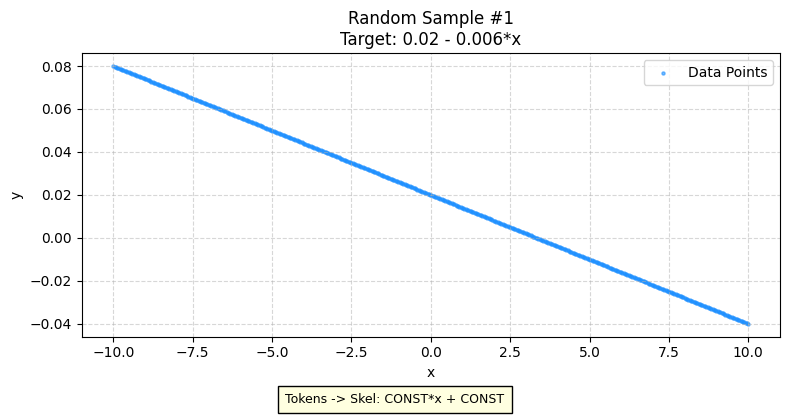

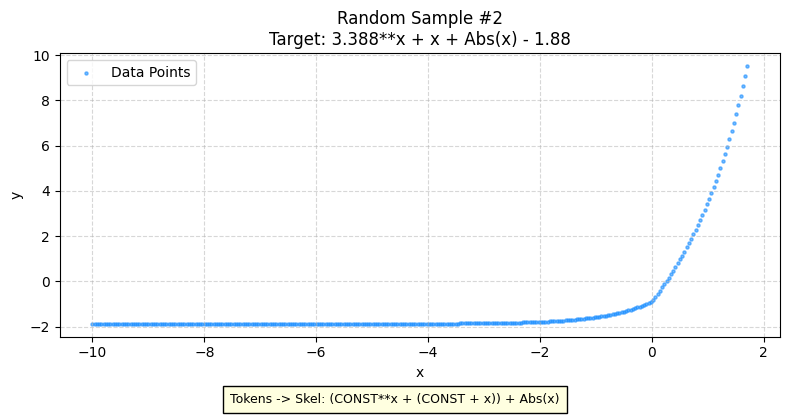

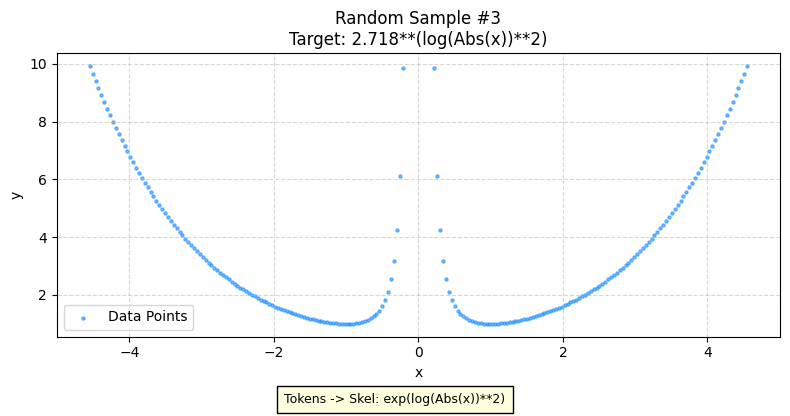

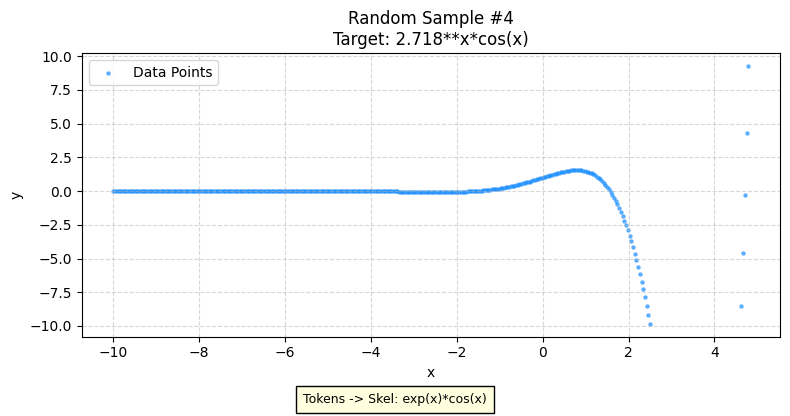

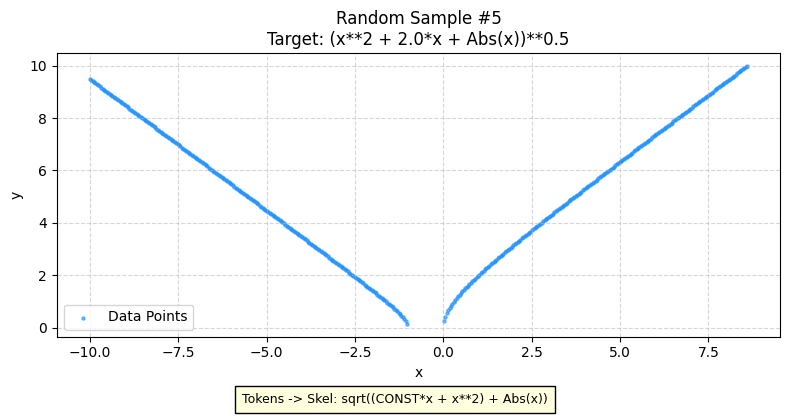

In [9]:
def visualize_collected_samples(samples, tokenizer):
    if not samples:
        print("❌ Нет примеров для отображения.")
        return

    print(f"📈 Отображение {len(samples)} случайных примеров из проверенных чанков:")

    for i, item in enumerate(samples):
        expr_str = item['expr_str']
        tokens = item['tokens']
        points = item['points'] # x, y, mask
        
        # Декодирование для проверки
        clean_tokens = tokens[(tokens != 0) & (tokens != 1) & (tokens != 2)] 
        try:
            reconstructed = tokenizer.token_seq_to_expr(clean_tokens)
        except:
            reconstructed = "Error"

        x = points[:, 0]
        y = points[:, 1]
        mask = points[:, 2].astype(bool)
        
        # Рисуем
        plt.figure(figsize=(8, 4))
        plt.scatter(x[mask], y[mask], s=5, c='dodgerblue', alpha=0.6, label='Data Points')
        
        plt.title(f"Random Sample #{i+1}\nTarget: {expr_str}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend()
        
        # Текст с восстановленным скелетом
        plt.figtext(0.5, -0.02, f"Tokens -> Skel: {reconstructed}", 
                    ha="center", fontsize=9, bbox={"facecolor":"lightyellow", "pad":5})
        
        plt.tight_layout()
        plt.show()

# Запускаем визуализацию
visualize_collected_samples(random_examples, tokenizer)